# Part 1
Understanding Stochastic Gradient Descent.
In this exercise, we want to implement [Stochastic Gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) without using a built-in optimizer, to understand how parameters are optimized at the low level.

Let's consider a toy problem of [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). The data generation process is such that we have one floating point variable $x \in [0,1]$, and one categorical variable $y\in \{0,1\}$. The Logistic Regression problem is to find the optimal parameters for the logistic function to predict the probability of $y$ given $x$.



The optimal parameters can be found numerically using gradient descent. In this case, we will be using SGD (batched gradient descent) to optimize the two parameters in the logistic function, $\beta_1, \beta_2$.

If ${p(x)={\frac {1}{1+e^{-(\beta _{1}+\beta _{2}x)}}}}$, then we want to find $\beta_1, \beta_2$ such that the [negative log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) is minimized. In this case, ${\ell =\sum _{k=1}^{K}\left(\,y_{k}\ln(p_{k})+(1-y_{k})\ln(1-p_{k})\right)}$, and the SGD formula is simply:
$\beta_i = \beta_{i-1} - \alpha * \nabla \ell$.

The data generation process as well as the pseudo-code is provided for you below, your task is to fill in the appropriate pytorch code. *Do not use the built-in optimizer*, implement SGD using tensor operations alone.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

In [ ]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 8)
labels = torch.split(label, 8) # Smaller mini-batches for finer gradient updates

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)


learning_rate = 0.1  # Higher learning rate for faster convergence
num_epochs = 200  # More epochs to achieve a better fit


for epoch in range(num_epochs):
    epoch_loss = 0
    for x, y in zip(inputs, labels):
        # Forward pass: Compute z = b1 + b2 * x and p(x) = sigmoid(z)
        z = b1 + b2 * x
        p_x = 1 / (1 + torch.exp(-z))  # Sigmoid function

        # Negative log-likelihood loss
        loss = -torch.mean(y * torch.log(p_x + 1e-8) + (1 - y) * torch.log(1 - p_x + 1e-8))
        epoch_loss += loss.item()


        loss.backward()

        # Update parameters using SGD
        with torch.no_grad():
            b1 -= learning_rate * b1.grad
            b2 -= learning_rate * b2.grad


            b1.grad.zero_()
            b2.grad.zero_()

    # Print epoch loss every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

# Plot Results

x_values = torch.linspace(0, 1, 1000)
decision_boundary = 1 / (1 + torch.exp(-(b1.item() + b2.item() * x_values)))


print("Final Parameters:")
print(f"β₁:{b1.item()}")
print(f"β₂:{b2.item()}")


Epoch 20, Loss: 27.9042
Epoch 40, Loss: 23.7000
Epoch 60, Loss: 22.1364
Epoch 80, Loss: 21.3299
Epoch 100, Loss: 20.8477
Epoch 120, Loss: 20.5336
Epoch 140, Loss: 20.3173
Epoch 160, Loss: 20.1624
Epoch 180, Loss: 20.0482
Epoch 200, Loss: 19.9621
Final Parameters:
β₁:-6.0627851486206055
β₂:17.367210388183594


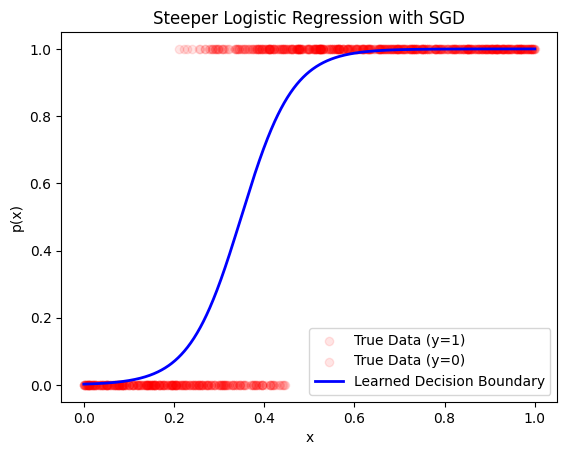

In [ ]:
# Plot the data points
plt.scatter(input[label == 1].numpy(), label[label == 1].numpy(), c='red', alpha=0.1, label="True Data (y=1)")
plt.scatter(input[label == 0].numpy(), label[label == 0].numpy(), c='red', alpha=0.1, label="True Data (y=0)")

# Plot the decision boundary
plt.plot(x_values.numpy(), decision_boundary.detach().numpy(), color='blue', label="Learned Decision Boundary", linewidth=2)

# Add labels, title, and legend
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.title("Steeper Logistic Regression with SGD")
plt.show()

# Part 2-1

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class Net(nn.Module):
    '''Model to regress 2D time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(64, 64)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(64, 2)    # Second hidden layer to output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.replace('-', np.nan)  # Replace '-' with NaN
        self.data = self.data.astype(float)  # Convert to float
        self.data.interpolate(method='linear', inplace=True)
        self.data.dropna(inplace=True)  # Remove rows with NaN values

        # Normalize data
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

        self.t = self.data['t'].values.reshape(-1, 1)
        self.x = self.scaler_x.fit_transform(self.data['x'].values.reshape(-1, 1)).flatten()  # Normalize x
        self.y = self.scaler_y.fit_transform(self.data['y'].values.reshape(-1, 1)).flatten()  # Normalize y
        self.labels = np.vstack((self.x, self.y)).T  # Stack x and y for labels

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return torch.tensor(self.t[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [ ]:
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 300

# Load dataset
dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Initialize the model, loss function, and optimizer
net = Net()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
def loss_fn(outputs, labels):
    return F.mse_loss(outputs, labels)

# Training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 20 == 19:  # Print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.078
[1,    40] loss: 0.069
[1,    60] loss: 0.068
[2,    20] loss: 0.066
[2,    40] loss: 0.057
[2,    60] loss: 0.066
[3,    20] loss: 0.062
[3,    40] loss: 0.061
[3,    60] loss: 0.060
[4,    20] loss: 0.061
[4,    40] loss: 0.053
[4,    60] loss: 0.058
[5,    20] loss: 0.061
[5,    40] loss: 0.053
[5,    60] loss: 0.056
[6,    20] loss: 0.053
[6,    40] loss: 0.055
[6,    60] loss: 0.055
[7,    20] loss: 0.050
[7,    40] loss: 0.054
[7,    60] loss: 0.053
[8,    20] loss: 0.048
[8,    40] loss: 0.050
[8,    60] loss: 0.051
[9,    20] loss: 0.051
[9,    40] loss: 0.051
[9,    60] loss: 0.046
[10,    20] loss: 0.046
[10,    40] loss: 0.049
[10,    60] loss: 0.050
[11,    20] loss: 0.048
[11,    40] loss: 0.047
[11,    60] loss: 0.050
[12,    20] loss: 0.051
[12,    40] loss: 0.050
[12,    60] loss: 0.044
[13,    20] loss: 0.046
[13,    40] loss: 0.051
[13,    60] loss: 0.047
[14,    20] loss: 0.043
[14,    40] loss: 0.053
[14,    60] loss: 0.051
[15,    20] loss: 0

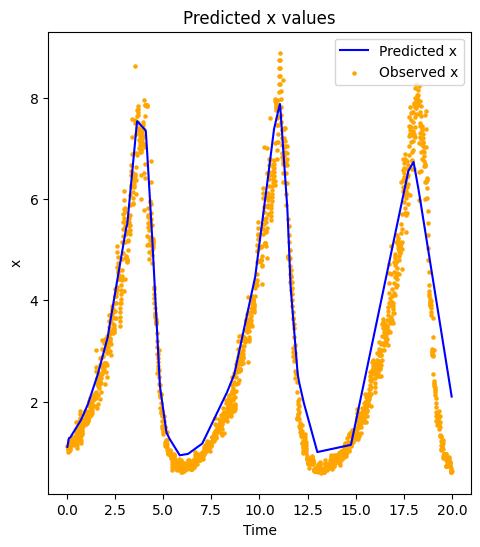

In [ ]:
with torch.no_grad():
    all_inputs = torch.tensor(dataset.t, dtype=torch.float32)
    predictions = net(all_inputs).numpy()

    # Inverse transform predictions to original scale
    predictions[:, 0] = dataset.scaler_x.inverse_transform(predictions[:, 0].reshape(-1, 1)).flatten()
    predictions[:, 1] = dataset.scaler_y.inverse_transform(predictions[:, 1].reshape(-1, 1)).flatten()

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Predicted x values")
plt.plot(dataset.t, predictions[:, 0], label='Predicted x', color='blue')
plt.scatter(dataset.t, dataset.scaler_x.inverse_transform(dataset.x.reshape(-1, 1)), label='Observed x', color='orange', s=5)
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()



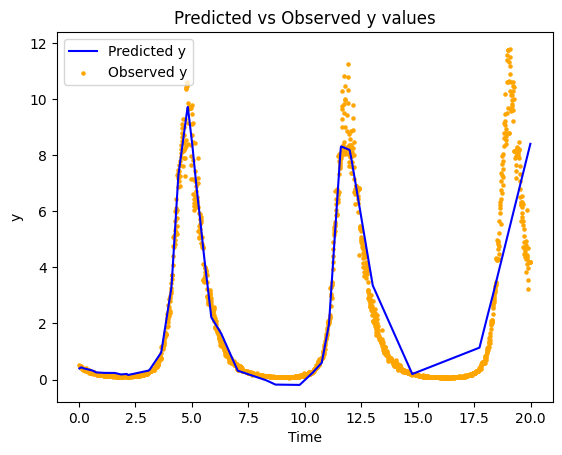

In [ ]:
plt.title("Predicted vs Observed y values")
plt.plot(dataset.t, predictions[:, 1], label='Predicted y', color='blue')  # Predicted y values
plt.scatter(dataset.t, dataset.scaler_y.inverse_transform(dataset.y.reshape(-1, 1)), label='Observed y', color='orange', s=5)  # Observed y values
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.show()

# Part 2-2 Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step output
        return out

class TimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.replace('-', np.nan).astype(float)
        self.data.interpolate(method='linear', inplace=True)
        self.data.dropna(inplace=True)

        # Normalize data
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

        self.t = self.data['t'].values
        self.x = self.scaler_x.fit_transform(self.data['x'].values.reshape(-1, 1)).flatten()
        self.y = self.scaler_y.fit_transform(self.data['y'].values.reshape(-1, 1)).flatten()

        self.seq_length = seq_length
        self.sequences = []
        self.labels = []

        for i in range(len(self.t) - seq_length):
            self.sequences.append(np.column_stack((self.t[i:i+seq_length], self.x[i:i+seq_length], self.y[i:i+seq_length])))
            self.labels.append([self.x[i + seq_length], self.y[i + seq_length]])

        self.sequences = np.array(self.sequences)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 300
SEQ_LENGTH = 5  # Number of previous time steps to consider

# Load dataset
dataset = TimeSeriesDataset('data.csv', SEQ_LENGTH)
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize the model, loss function, and optimizer
input_size = 3  # t, x, y
hidden_size = 64
output_size = 2  # predicting x and y
model = LSTMModel(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{EPOCHS}], Loss: {running_loss/len(trainloader):.4f}')

# Prepare for extrapolation
# We will predict values beyond t = 20
predictions = []
last_sequence = dataset.sequences[-1].reshape(1, SEQ_LENGTH, input_size)  # Get the last sequence for prediction

# Predicting up to t = 100
for t in range(21, 101):
    with torch.no_grad():
        next_pred = model(torch.tensor(last_sequence, dtype=torch.float32))
        predictions.append(next_pred.numpy().flatten())

        # Prepare the next input sequence
        new_sequence = np.array([[t, predictions[-1][0], predictions[-1][1]]])  # [t, predicted x, predicted y]
        last_sequence = np.append(last_sequence[:, 1:, :], new_sequence.reshape(1, 1, input_size), axis=1)

# Convert predictions back to original scale
predictions = np.array(predictions)
predicted_x = dataset.scaler_x.inverse_transform(predictions[:, 0].reshape(-1, 1)).flatten()
predicted_y = dataset.scaler_y.inverse_transform(predictions[:, 1].reshape(-1, 1)).flatten()


Epoch [0/300], Loss: 0.0678
Epoch [10/300], Loss: 0.0014
Epoch [20/300], Loss: 0.0012
Epoch [30/300], Loss: 0.0012
Epoch [40/300], Loss: 0.0011
Epoch [50/300], Loss: 0.0010
Epoch [60/300], Loss: 0.0009
Epoch [70/300], Loss: 0.0009
Epoch [80/300], Loss: 0.0008
Epoch [90/300], Loss: 0.0009
Epoch [100/300], Loss: 0.0008
Epoch [110/300], Loss: 0.0008
Epoch [120/300], Loss: 0.0008
Epoch [130/300], Loss: 0.0008
Epoch [140/300], Loss: 0.0008
Epoch [150/300], Loss: 0.0008
Epoch [160/300], Loss: 0.0008
Epoch [170/300], Loss: 0.0008
Epoch [180/300], Loss: 0.0008
Epoch [190/300], Loss: 0.0008
Epoch [200/300], Loss: 0.0008
Epoch [210/300], Loss: 0.0008
Epoch [220/300], Loss: 0.0008
Epoch [230/300], Loss: 0.0007
Epoch [240/300], Loss: 0.0008
Epoch [250/300], Loss: 0.0007
Epoch [260/300], Loss: 0.0008
Epoch [270/300], Loss: 0.0007
Epoch [280/300], Loss: 0.0007
Epoch [290/300], Loss: 0.0008


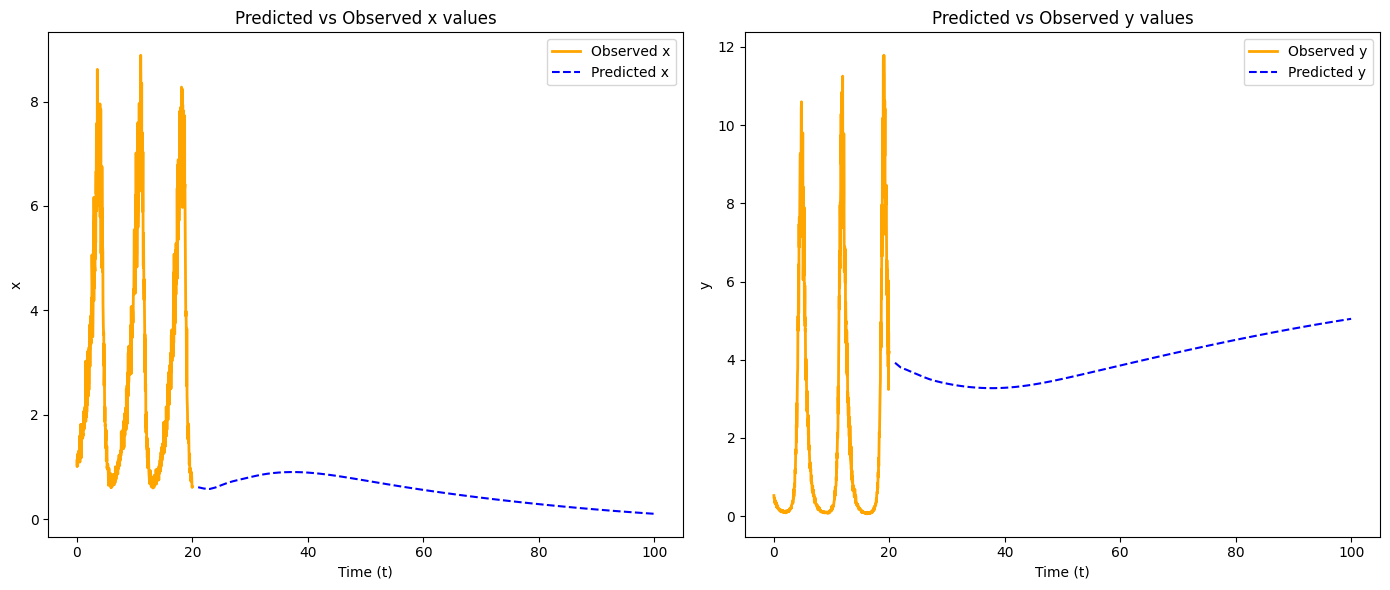

In [ ]:


# Extract original observed values for t <= 20
observed_x = dataset.scaler_x.inverse_transform(dataset.x.reshape(-1, 1)).flatten()
observed_y = dataset.scaler_y.inverse_transform(dataset.y.reshape(-1, 1)).flatten()
observed_t = dataset.t

# Create a time vector for predictions
predicted_t = np.arange(21, 101)  # from t=21 to t=100

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot for x values
plt.subplot(1, 2, 1)
plt.title("Predicted vs Observed x values")
plt.plot(observed_t, observed_x, label='Observed x', color='orange', linewidth=2)  # Observed x values
plt.plot(predicted_t, predicted_x, label='Predicted x', color='blue', linestyle='--')  # Predicted x values
plt.xlabel('Time (t)')
plt.ylabel('x')
plt.legend()

# Plot for y values
plt.subplot(1, 2, 2)
plt.title("Predicted vs Observed y values")
plt.plot(observed_t, observed_y, label='Observed y', color='orange', linewidth=2)  # Observed y values
plt.plot(predicted_t, predicted_y, label='Predicted y', color='blue', linestyle='--')  # Predicted y values
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

# **Problem Overview**
The goal of this project is to develop a predictive model capable of forecasting future values in a time series dataset, specifically for variables ( x ) and ( y ) based on a time variable ( t ). The challenge lies in accurately extrapolating predictions beyond the training range, which is limited to ( t \in [0, 20] ), and extending the predictions up to ( t = 100 ).

# **Key Components of the Problem:**

1. Time Series Data:

The dataset consists of time-indexed observations where each entry includes a timestamp ( t ) along with corresponding values ( x ) and ( y ). The data may have missing values or noise, requiring preprocessing steps such as interpolation and normalization.

2.   Extrapolation Challenge:


Traditional predictive models may struggle with extrapolation, especially when trained only on a limited range of data. The model must learn the underlying trends and patterns in the data to make reliable predictions for values of ( t ) that it has never encountered.



3.  Model Selection:

Selecting an appropriate model architecture is crucial. The model should effectively capture temporal dependencies within the data. Options include Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, or Temporal Convolutional Networks (TCNs).

4.  Data Preparation:

The input data needs to be structured in a way that the model can learn from historical sequences. This often involves creating sliding windows of past observations to predict future values.

5.  Training Procedure:

The model must be trained on the available data while avoiding overfitting. Techniques such as early stopping, validation sets, and appropriate loss functions are essential to ensure generalization.

6.  Evaluation:

After training, the model's performance must be evaluated on both the training data and the extrapolated predictions. Visualizations can help assess how well the model captures the observed data and extends predictions into the future.

7.  Visualization:

It is important to visualize both the observed and predicted values to understand the model's performance and its ability to extrapolate beyond the training range.

# **Objectives:**
1.  Develop a Predictive Model: Create a model that can predict future values of ( x ) and ( y ) based on historical time series data.
2.  Extrapolation Capability: Ensure the model can effectively extrapolate predictions for ( t > 20 ) up to ( t = 100 ).
3.  Data Handling: Implement preprocessing steps to handle missing values and normalize the data for better model performance.
4.  Performance Evaluation: Evaluate the model's performance through quantitative metrics and visualizations to understand its predictive capabilities.

# **Conclusion:**
This project aims to address the challenges of time series forecasting, particularly the ability to extrapolate beyond the training data. By leveraging advanced neural network architectures and proper data handling techniques, the goal is to create a robust predictive model that can provide reliable forecasts for future time points.

# Part 3-1a

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

In [ ]:

import numpy as np

def min_dist(points, res):
    """
    Calculates a 2D array with the minimum distance from each pixel to data points.

    Inputs:
        * points: a python list of 2D coordinates, normalized in the range [0, 1]
        * res: the resolution of the output array.
    Returns:
        A res x res square array with floating point values corresponding to the
        Euclidean distance to the closest point in points.
    """
    # Create a grid of pixel coordinates
    x = np.linspace(0, 1, res)
    y = np.linspace(0, 1, res)
    xv, yv = np.meshgrid(x, y)

    # Stack the pixel coordinates into a 2D array of shape (res, res, 2)
    pixel_coords = np.stack((xv, yv), axis=-1)

    # Convert the list of points to a NumPy array
    points = np.array(points)

    # Calculate the distance from each pixel to each point
    distances = np.linalg.norm(pixel_coords[:, :, np.newaxis, :] - points[np.newaxis, np.newaxis, :, :], axis=-1)

    # Find the minimum distance for each pixel
    min_distances = np.min(distances, axis=-1)

    return min_distances


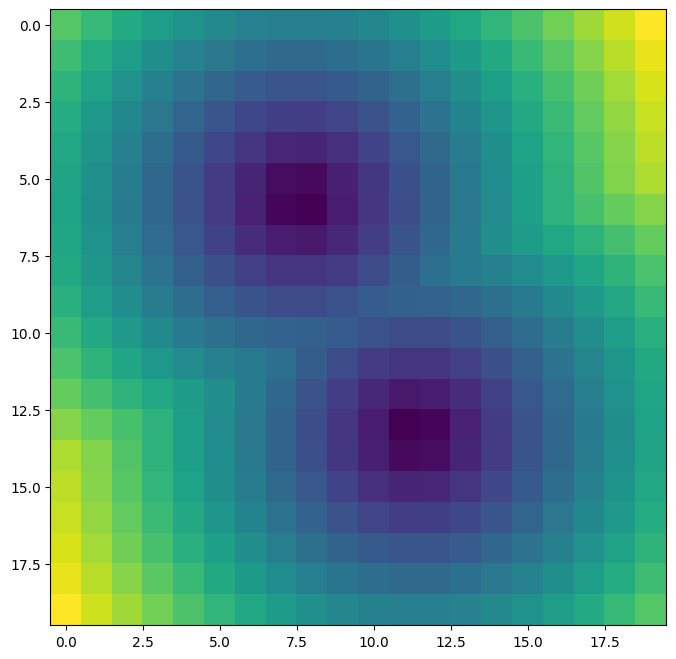

In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

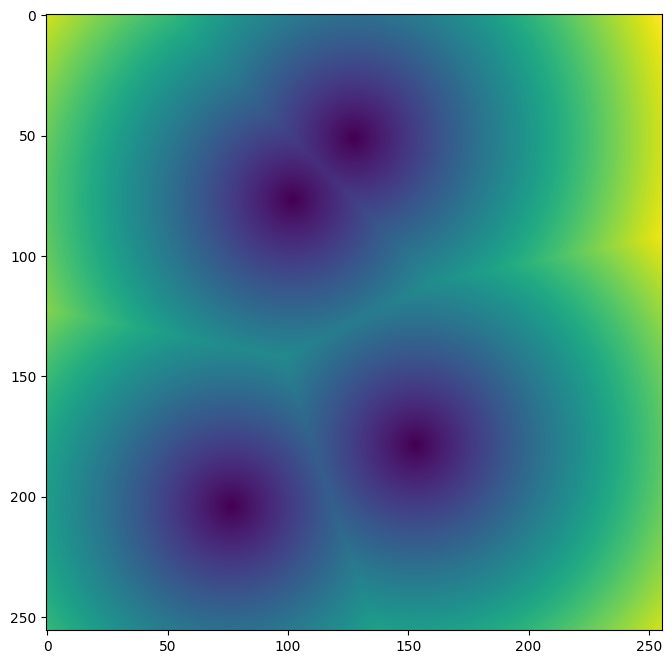

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

# Part 3-1b: Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def create_points(batch_size, num_points):
    """Generates random points in a normalized range [0, 1]."""
    coords = np.random.rand(batch_size, num_points, 2)
    return torch.tensor(coords, dtype=torch.float32)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


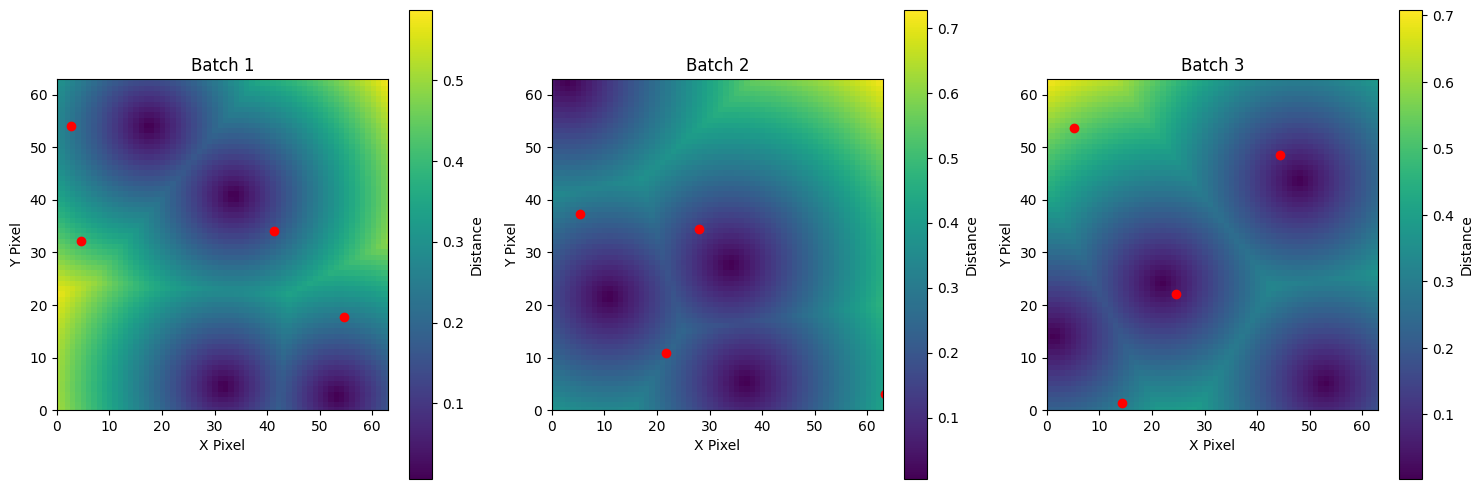

In [ ]:

def min_dist(points, res):
    """Calculates a 3D tensor with the minimum distance from each pixel to data."""
    batch_size, num_points, _ = points.shape

    # Create a grid of pixel coordinates
    x = torch.linspace(0, 1, res)
    y = torch.linspace(0, 1, res)
    grid_x, grid_y = torch.meshgrid(x, y)
    grid = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1)

    # Expand grid to match batch size
    grid = grid[None, :, :].expand(batch_size, -1, -1)

    # Calculate the Euclidean distances from each pixel to each point
    distances = torch.norm(grid[:, :, None, :] - points[:, None, :, :], dim=-1)

    # Find the minimum distance for each pixel
    min_distances = distances.min(dim=2)[0]

    # Reshape to the output tensor shape
    return min_distances.view(batch_size, res, res)

# Example usage:
batch_size = 3
num_points = 4
resolution = 64

# Generate random points
points = create_points(batch_size, num_points)

# Calculate minimum distances
result = min_dist(points, resolution)

# Plotting the results
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    img = axes[i].imshow(result[i].detach().numpy(), cmap='viridis', origin='lower')
    axes[i].scatter(points[i, :, 0].numpy() * resolution, points[i, :, 1].numpy() * resolution,
                    color='red', label='Data Points')
    axes[i].set_title(f'Batch {i + 1}')
    axes[i].set_xlabel('X Pixel')
    axes[i].set_ylabel('Y Pixel')
    axes[i].set_xlim(0, resolution - 1)
    axes[i].set_ylim(0, resolution - 1)

    # Add a colorbar for each subplot
    fig.colorbar(img, ax=axes[i], orientation='vertical', label='Distance')

plt.tight_layout()
plt.show()

# Part 3-2: Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

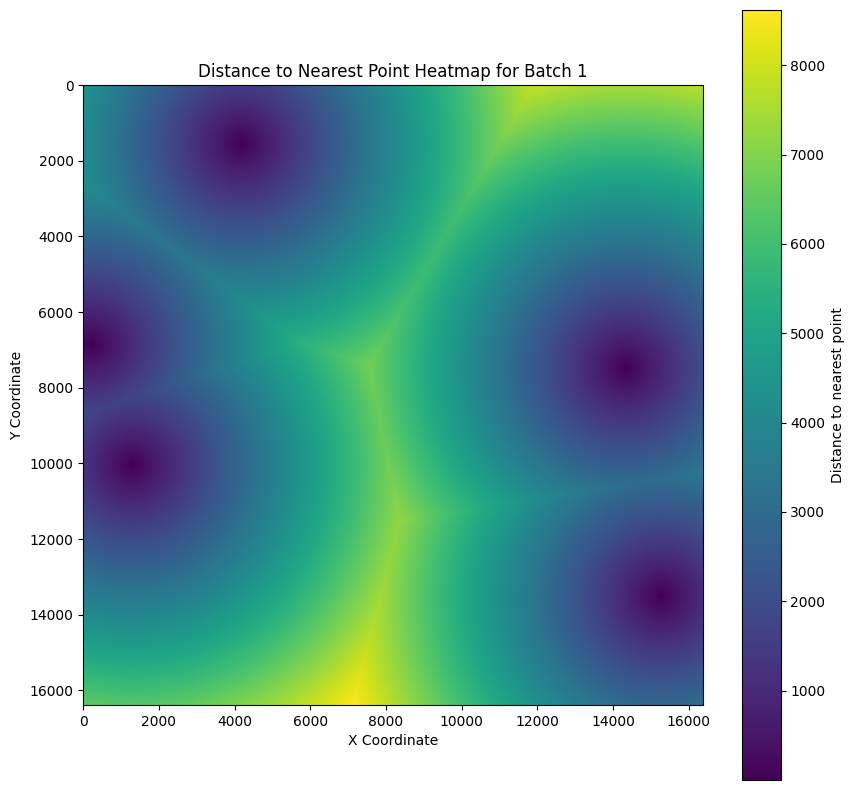

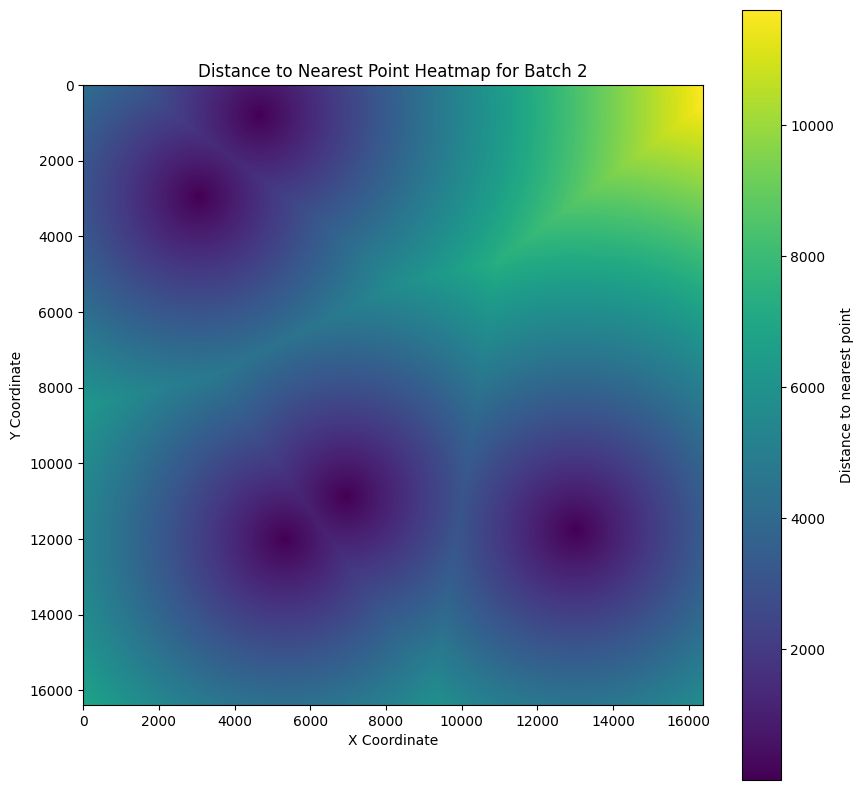

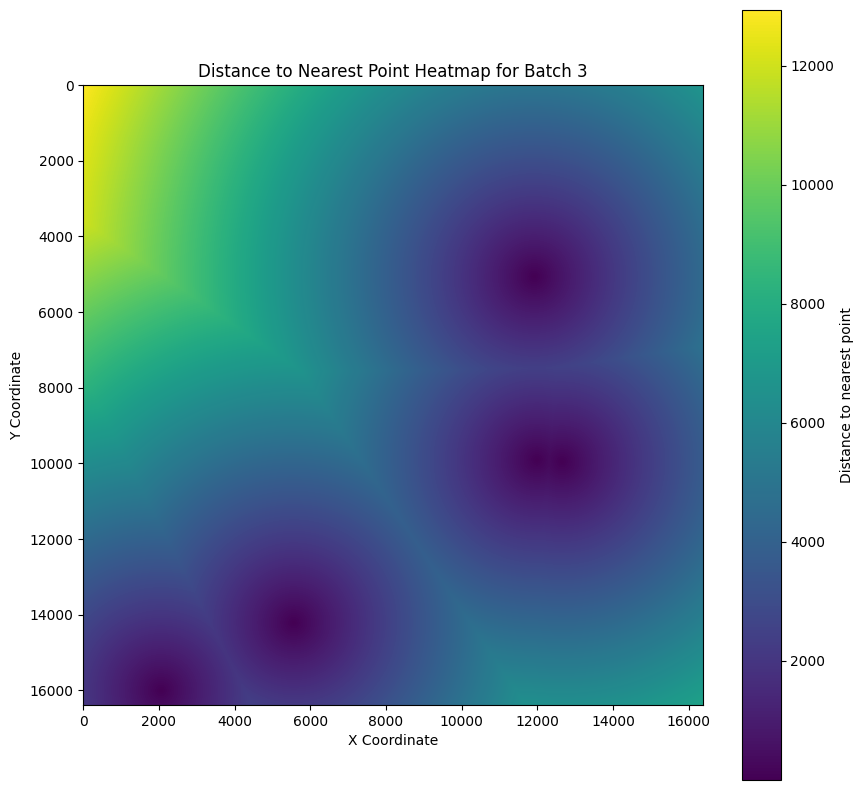

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def create_points(batch_size, num_points):
    """Generate random 2D coordinates for a given batch size and number of points."""
    coords = np.random.rand(batch_size, num_points, 2) * 16384  # Scale to the resolution
    return coords

def min_dist(points, res, chunk_size=512):
    """Compute the minimum distance from each pixel to the nearest point using chunk processing."""
    # Convert points to a tensor
    points_tensor = torch.tensor(points, dtype=torch.float32)

    # Prepare a tensor to hold the minimum distances
    min_distances = torch.full((res, res), float('inf'), dtype=torch.float32)

    # Process the grid in chunks
    for x_start in range(0, res, chunk_size):
        for y_start in range(0, res, chunk_size):
            x_end = min(x_start + chunk_size, res)
            y_end = min(y_start + chunk_size, res)

            # Create a grid of pixel coordinates for the current chunk
            x_coords = torch.arange(x_start, x_end).unsqueeze(1)  # Shape (chunk_size, 1)
            y_coords = torch.arange(y_start, y_end).unsqueeze(0)  # Shape (1, chunk_size)
            grid = torch.stack(torch.meshgrid(x_coords.squeeze(), y_coords.squeeze(), indexing='ij'), dim=-1)  # Shape (chunk_size, chunk_size, 2)

            # Reshape the grid to compute distances
            grid_flat = grid.view(-1, 2)  # Shape (chunk_size*chunk_size, 2)

            # Compute distances from each pixel in the chunk to each point
            distances = torch.norm(grid_flat.unsqueeze(1) - points_tensor.unsqueeze(0), dim=2)  # Shape (chunk_size*chunk_size, num_points)

            # Find the minimum distance for each pixel in the chunk
            min_distances_chunk = distances.min(dim=1)[0]  # Shape (chunk_size*chunk_size)

            # Reshape back to the chunk shape and store in the result tensor
            min_distances[x_start:x_end, y_start:y_end] = min_distances_chunk.view(x_end - x_start, y_end - y_start)

    return min_distances

# Parameters
batch_size = 3  # Number of batches
num_points = 5  # Number of points per batch
res = 16384  # High resolution

# Generate random points
random_points = create_points(batch_size, num_points)

# Compute min distances for each batch and plot the results
for i in range(batch_size):
    result_tensor = min_dist(random_points[i], res)

    # Plotting the result for each batch
    plt.figure(figsize=(10, 10))
    plt.imshow(result_tensor.cpu().numpy(), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Distance to nearest point')
    plt.title(f'Distance to Nearest Point Heatmap for Batch {i + 1}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()